<img src="https://raw.githubusercontent.com/EO-College/cubes-and-clouds/main/icons/cnc_3icons_share_cirlce.svg"
     alt="Cubes & Clouds logo"
     style="float: center; margin-right: 10px;" />

# 3.4 Data Sharing
Science is much more impactful once it's shared. Therefore, we are going to learn how to 
open up our scientific output from a cloud platform, so that is openly available - and 
has the chance to make the impact it should.
- Load data,
- Select AOI,
- Recreate process graph, 
- Download results for one time-step, 
- Generate STAC


## Libraries

In [1]:
import json

import openeo
import numpy as np
import leafmap

import geopandas as gpd
import shapely
from shapely.geometry import Polygon

import rioxarray as rio
import xarray

Import utility functions

In [2]:
%run cubes_utilities.py

## Login

Connect to the copernicus dataspace ecosystem.

In [3]:
conn = openeo.connect('https://openeo.dataspace.copernicus.eu/')

Authenticate login

In [4]:
conn.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.1/' with OidcBearerAuth>

Check if the login worked

In [ ]:
conn.describe_account()

## Select a Point of Interest
Start by selecting a center point of the area you would like to analyse from the map shown below

In [5]:
m = leafmap.Map(center=(46.497012, 11.356429), zoom=14)
m

Map(center=[46.497012, 11.356429], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title',…

In [6]:
feat = m.draw_features
geom = feat[0]['geometry']['coordinates']

In [7]:
distance_km = 1
# Create a bounding box around the point
bbox = create_bounding_box(geom[0], geom[1], distance_km)
visualize_bbox(m, bbox)

## Recreate process graph

In [8]:
temporal_extent = ["2018-01-01", "2018-02-15"]
snow_map_4dcube = calculate_sca(conn, bbox, temporal_extent)
snow_map_4dcube

## Reduce dimension

In [9]:
snow_map_3dcube = snow_map_4dcube.reduce_dimension(reducer="median", dimension="t")
snow_map_3dcube

### Download result

In [11]:
snowmap_cog = snow_map_3dcube.save_result(format = "GTiff", options = {"overviews": "AUTO"})

In [12]:
snowmap_cog.download("results/snowmap3d.tif")

In [13]:
snowmap = rio.open_rasterio("results/snowmap3d.tif",decode_coords="all")
snowmap

<xarray.DataArray (band: 1, y: 209, x: 145)>
[30305 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 6.838e+05 6.838e+05 ... 6.853e+05 6.853e+05
  * y            (y) float64 5.157e+06 5.157e+06 ... 5.155e+06 5.155e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:        Area
    PROCESSING_SOFTWARE:  0.18.0a1
    _FillValue:           nan
    scale_factor:         1.0
    add_offset:           0.0

### Visualize result

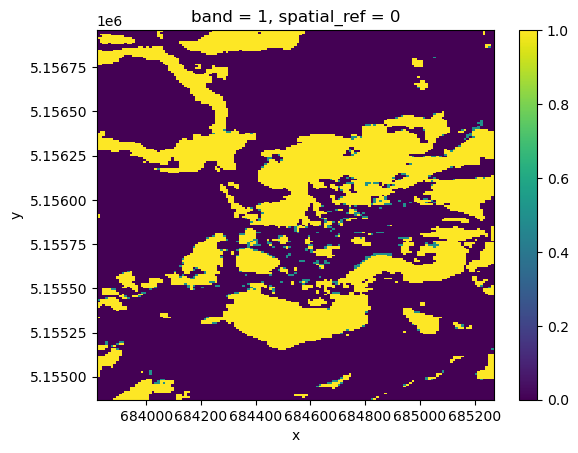

In [14]:
snowmap.plot()

## Generate STAC Item

An introduction to data sharing using the SpatioTemporal Assets Catalog (STAC) specification, which is now consider a defacto standard for geospatial data discovery and indexing


Fill in the stac configuration with the right path and properties to share, you can 
modify the example in the next code block

In [15]:
assets = [
    {"name": "SnowmapBolzano", "path": "results/snowmap3d.tif", "href": None,"role": None}
    # {"name": "Snowmap_2", "path": "results/snowmap3d_2.tif", "href": None,"role": None}
]

media_type = pystac.MediaType.COG
properties = {}
input_datetime = None
id = "snowmap_stac"

# to generate a collection, you need to specify the link
collection = "Snowmap Bolzano"
collection_url = None

In [16]:
stac_item = generate_stac(assets, media_type, id="Snow_map",
              collection=None, collection_url=None,
              input_datetime=None, properties = {})
stac_item

<Item id=Snow_map>

#### Validate and save STAC

In [17]:
stac_item.validate()

['https://schemas.stacspec.org/v1.0.0/item-spec/json-schema/item.json',
 'https://stac-extensions.github.io/projection/v1.1.0/schema.json',
 'https://stac-extensions.github.io/raster/v1.1.0/schema.json',
 'https://stac-extensions.github.io/eo/v1.1.0/schema.json']

In [18]:
print(json.dumps(stac_item.to_dict(), indent=4))

{
    "type": "Feature",
    "stac_version": "1.0.0",
    "id": "Snow_map",
    "properties": {
        "datetime": "2023-11-02T13:17:26.243970Z"
    },
    "geometry": {
        "type": "Polygon",
        "coordinates": [
            [
                [
                    11.396629724583162,
                    46.52188625378429
                ],
                [
                    11.41635141628225,
                    46.52188625378429
                ],
                [
                    11.41635141628225,
                    46.54107626164202
                ],
                [
                    11.396629724583162,
                    46.54107626164202
                ],
                [
                    11.396629724583162,
                    46.52188625378429
                ]
            ]
        ]
    },
    "links": [],
    "assets": {
        "SnowmapBolzano": {
            "href": "results/snowmap3d.tif",
            "type": "image/tiff; application=geotiff; 

In [19]:
stac_json = json.dumps(stac_item.to_dict())
with open("results/stac_item.json", "w") as file:
    file.write(stac_json)